In [1]:
from generalized_hopfield_model import *
import matplotlib.pyplot as plt 
import scipy as sp 
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import umap

C:\Users\csfloyd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#get MNIST digits and labels 
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"]

#format labels such that each image corresponds to a 10 length vector. Digit corresponds to the position with value 1, otherwise values are -1 
all_y = y.astype(np.int64)
all_Ls = -1*np.ones((all_y.shape[0],10))
all_Ls[np.arange(y.shape[0]),all_y] = 1 

#renormalize digit pixel values to values in [-1,1] 
all_Ms = 2*X/np.max(X) - 1.0

#plot a digit
# digit_idx = 0
# fig,ax = plt.subplots()
# im = ax.imshow(all_Ms[digit_idx].reshape(28,28), cmap='bwr', vmin=-1, vmax=1)
# cax = ax.inset_axes([1.04, 0.0, 0.05, 1.0])
# cbar = fig.colorbar(im,cax=cax)
# ax.set_aspect('equal')
# ax.set_title('Digit '+str(np.argmax(all_Ls[digit_idx])))

C:\Users\csfloyd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [18]:
true_labels = []
probabilities = []
predicted_labels = []
sm_inv_temp = 100   
test_set = np.arange(1000)
for test_idx in test_set:
    true_labels.append(all_y[test_idx])
    probabilities.append(softmax(sm_inv_temp * net.output(all_Ms[test_idx])))
    predicted_labels.append(np.argmax(probabilities[-1]))
    
def compute_marginal_distribution(net, all_Ms, n_nodes, n_classes, n_samples=1000, sm_inv_temp=100):
    marginal_probs = np.zeros(n_nodes)
    for _ in range(n_samples):
        class_number = random.randrange(n_classes)
        # Randomly select an index for the given class
        indices = np.where(all_y == class_number)[0]
        if len(indices) == 0:
            continue
        idx = np.random.choice(indices)
        inputs = all_Ms[idx]
        probs = softmax(sm_inv_temp * net.output(inputs))
        marginal_probs += probs
    marginal_probs /= n_samples
    return marginal_probs

def compute_mi_density(net, inputs, marginal_probs, sm_inv_temp=100):
    probs = softmax(sm_inv_temp * net.output(inputs))
    return np.sum(probs * np.log(probs / marginal_probs))

def compute_MI(net, all_Ms, all_y, n_nodes, n_classes, n_samples=1000, moment=1, sm_inv_temp=100):
    marginal_probs = compute_marginal_distribution(net, all_Ms, n_nodes, n_classes, n_samples, sm_inv_temp)
    mi = 0
    for _ in range(n_samples):
        class_number = random.randrange(n_classes)
        indices = np.where(all_y == class_number)[0]
        if len(indices) == 0:
            continue
        idx = np.random.choice(indices)
        inputs = all_Ms[idx]
        probs = softmax(sm_inv_temp * net.output(inputs))
        mi += (np.sum(probs * np.log(probs / marginal_probs))) ** moment
    mi /= n_samples
    return mi / np.log(2)

In [39]:
# we can load predefined memory and label states 
file_path = '/Users/csfloyd/Dropbox/Projects/MarkovComputation/Data/'
M_len = int(28*28) # length of memories; length of flattened digit pixels
L_len = 10 # length of label vector; 10 digits (0,1,2,3,4,5,6,7,8,9)
learning_rate = 0.005 # learning rate by which we nudge the memories and labels in direction of their gradient
rand_mean = -0.003 # mean
rand_std = 1e-5 # standard deviation

# n_deg = 30 # exponent of the f_n function of the GHN
# Temperature = 0.85*M_len # pseudo-temperature of the f_n argument
# N_mem = 1000 # number of memories in our GHN
# N_digit_samples = 500 # number of samples to which to train each digit
# epochs = 10500 
# t_resolution = 25 

n_deg = 10 # exponent of the f_n function of the GHN
Temperature = 0.85*M_len # pseudo-temperature of the f_n argument
N_mem = 100 # number of memories in our GHN
N_digit_samples = 100 # number of samples to which to train each digit
epochs = 5000 
t_resolution = 10 

lib_Ms = np.load(file_path+'Mems_n_deg_'+str(n_deg)+'_T_'+str(Temperature)+'_K_'+str(N_mem)+'_N-d-samps_'+str(N_digit_samples)+'_epochs_'+str(epochs)+'_t-resolution_'+str(t_resolution)+'.npy')
lib_Ls = np.load(file_path+'Labels_n_deg_'+str(n_deg)+'_T_'+str(Temperature)+'_K_'+str(N_mem)+'_N-d-samps_'+str(N_digit_samples)+'_epochs_'+str(epochs)+'_t-resolution_'+str(t_resolution)+'.npy')
net = GHN(M_len=M_len, L_len=L_len, K=N_mem, n_deg=n_deg, Temp=Temperature, m_deg=n_deg, dt=learning_rate, momentum=0., rand_mean=rand_mean, rand_std=rand_std, load_data=True, Mems=lib_Ms[-1], Labels=lib_Ls[-1])


# we could test how well our model can classify a test case; this could definitely be done more efficiently or in a loop to quantify the network's ability 
test_idx = 10
def softmax(x):
    exp_x = np.exp(x - np.max(x))  # Subtract max for numerical stability
    return exp_x / exp_x.sum()
print(net.output(all_Ms[test_idx]))
print(softmax(100 * net.output(all_Ms[test_idx])))
print(all_y[test_idx])



[-0.17104494 -0.13031257 -0.11360825  0.01856527 -0.18285905 -0.03137323
 -0.16330507 -0.14891886 -0.06131717 -0.14167101]
[5.78430777e-09 3.39809385e-07 1.80590482e-06 9.92929073e-01
 1.77488799e-09 6.73156940e-03 1.25426506e-08 5.28657804e-08
 3.37029306e-04 1.09130127e-07]
3


In [41]:
import random

# Example parameters
n_nodes = 10  # Number of output nodes/classes, e.g., 10 for MNIST
n_classes = 10
n_samples = 5000
sm_inv_temp = 100

# Compute the marginal distribution over the outputs
marginal_probs = compute_marginal_distribution(
    net, all_Ms, n_nodes, n_classes, n_samples, sm_inv_temp
)
print("Marginal probabilities:", marginal_probs)

# Compute MI density for a single sample (e.g., the first test sample)
test_idx = 0
inputs = all_Ms[test_idx]
mi_density = compute_mi_density(net, inputs, marginal_probs, sm_inv_temp)
print(f"MI density for sample {test_idx}:", mi_density)

# Compute the overall mutual information (MI) estimate
mi = compute_MI(
    net, all_Ms, all_y, n_nodes, n_classes, n_samples, moment=1, sm_inv_temp=sm_inv_temp
)

mi_sm = compute_MI(
    net, all_Ms, all_y, n_nodes, n_classes, n_samples, moment=2, sm_inv_temp=sm_inv_temp
)

print("Estimated mutual information (bits):", mi)
print("Estimated mutual information second moment (bits):", mi_sm)
print("Estimated mutual information second moment / first moment squared (bits):", mi_sm / (mi**2))

Marginal probabilities: [0.119234   0.1197769  0.07841028 0.08320347 0.10404611 0.09772279
 0.09885486 0.08960655 0.08131671 0.12782833]
MI density for sample 0: 1.738988958823833
Estimated mutual information (bits): 2.495607084601286
Estimated mutual information second moment (bits): 4.748221934867438
Estimated mutual information second moment / first moment squared (bits): 0.7623924560387476


In [16]:
# we could test how well our model can classify a test case; this could definitely be done more efficiently or in a loop to quantify the network's ability 
def softmax(x):
    exp_x = np.exp(x - np.max(x))  # Subtract max for numerical stability
    return exp_x / exp_x.sum()

true_labels = []
probabilities = []
predicted_labels = []
sm_inv_temp = 100   
test_set = np.arange(1000)
for test_idx in test_set:
    true_labels.append(all_y[test_idx])
    probabilities.append(softmax(sm_inv_temp * net.output(all_Ms[test_idx])))
    predicted_labels.append(np.argmax(probabilities[-1]))


# Calculate accuracy
accuracy = np.mean(np.array(true_labels) == np.array(predicted_labels)) * 100
print(f"Classification accuracy: {accuracy:.2f}%")



Classification accuracy: 91.20%


In [3]:
# choose parameters for generalized hopfield network (GHN)
M_len = int(28*28) # length of memories; length of flattened digit pixels
L_len = 10 # length of label vector; 10 digits (0,1,2,3,4,5,6,7,8,9)
N_mem = 100 # number of memories in our GHN
n_deg = 30 # exponent of the f_n function of the GHN
Temperature = 0.85*M_len # pseudo-temperature of the f_n argument
learning_rate = 0.005 # learning rate by which we nudge the memories and labels in direction of their gradient
# we initialize memories and labels (which will be optimized) using normal distributions with the following moments
rand_mean = -0.003 # mean
rand_std = 1e-5 # standard deviation

# we instantiate/create the network 
net = GHN(M_len=M_len, L_len=L_len, K=N_mem, n_deg=n_deg, Temp=Temperature, m_deg=n_deg, dt=learning_rate, momentum=0., rand_mean=rand_mean, rand_std=rand_std)

In [4]:
# divide digits and labels into training and test sets (although we do not test in this notebook)
N_imgs = len(y)
N_train = 60000
N_test = N_imgs - N_train

train_y = all_y[:N_train]
train_Ls = all_Ls[:N_train]
train_Ms = all_Ms[:N_train]

def get_digits_idxs(sel_digits,Set,Num):
    # function which extracts specific number of samples per selected digits from a specific set
    d_idxs = np.empty(len(sel_digits)*Num, dtype=np.int64)
    for i,dig in enumerate(sel_digits):
        dig_idxs = np.where(Set == dig)[0]
        d_idxs[i*Num:(i+1)*Num] = dig_idxs[:Num]
    return d_idxs

SDs = np.arange(10) # which digits do we want to train our network 
N_digit_samples = 100 # number of samples to which to train each digit

t_idxs = get_digits_idxs(SDs, train_y, N_digit_samples)

# training variables 
t_Ls = train_Ls[t_idxs,:] #training labels 
t_Ms = train_Ms[t_idxs,:] #traning memories/digits 
epochs = 5000 

# saving trained memories and labels parameters 
t_resolution = 10 
lib_Ms = np.empty((epochs//t_resolution, N_mem, int(28*28)))
lib_Ls = np.empty((epochs//t_resolution, N_mem, 10))

# training cycle
for k in range(epochs):
    net.train_protocol(t_Ms, t_Ls, 0.0, 0.0)
    if k%t_resolution == 0:
        lib_Ms[k//t_resolution] = net.Ms
        lib_Ls[k//t_resolution] = net.Ls
        print('done with '+str(k)+' epochs')

done with 0 epochs
done with 10 epochs
done with 20 epochs
done with 30 epochs
done with 40 epochs
done with 50 epochs
done with 60 epochs
done with 70 epochs
done with 80 epochs
done with 90 epochs
done with 100 epochs
done with 110 epochs
done with 120 epochs
done with 130 epochs
done with 140 epochs
done with 150 epochs
done with 160 epochs
done with 170 epochs
done with 180 epochs
done with 190 epochs
done with 200 epochs
done with 210 epochs
done with 220 epochs
done with 230 epochs
done with 240 epochs
done with 250 epochs
done with 260 epochs
done with 270 epochs
done with 280 epochs
done with 290 epochs
done with 300 epochs
done with 310 epochs
done with 320 epochs
done with 330 epochs
done with 340 epochs
done with 350 epochs
done with 360 epochs
done with 370 epochs
done with 380 epochs
done with 390 epochs
done with 400 epochs
done with 410 epochs
done with 420 epochs
done with 430 epochs
done with 440 epochs
done with 450 epochs
done with 460 epochs
done with 470 epochs
don

In [5]:
# save trayectory of trained parameters of the GHN; (# of cycles, # of memories in GHN, vector length)
file_path = '/Users/csfloyd/Dropbox/Projects/MarkovComputation/Data/'
np.save(file_path+'Mems_n_deg_'+str(n_deg)+'_T_'+str(Temperature)+'_K_'+str(N_mem)+'_N-d-samps_'+str(N_digit_samples)+'_epochs_'+str(epochs)+'_t-resolution_'+str(t_resolution)+'.npy', np.concatenate((lib_Ms,net.Ms.reshape((1,N_mem,M_len)))))
np.save(file_path+'Labels_n_deg_'+str(n_deg)+'_T_'+str(Temperature)+'_K_'+str(N_mem)+'_N-d-samps_'+str(N_digit_samples)+'_epochs_'+str(epochs)+'_t-resolution_'+str(t_resolution)+'.npy', np.concatenate((lib_Ls,net.Ls.reshape((1,N_mem,L_len)))))

In [16]:
# we can load predefined memory and label states 
lib_Ms = np.load(file_path+'Mems_n_deg_'+str(n_deg)+'_T_'+str(Temperature)+'_K_'+str(N_mem)+'_N-d-samps_'+str(N_digit_samples)+'_epochs_'+str(epochs)+'_t-resolution_'+str(t_resolution)+'.npy')
lib_Ls = np.load(file_path+'Labels_n_deg_'+str(n_deg)+'_T_'+str(Temperature)+'_K_'+str(N_mem)+'_N-d-samps_'+str(N_digit_samples)+'_epochs_'+str(epochs)+'_t-resolution_'+str(t_resolution)+'.npy')
net = GHN(M_len=M_len, L_len=L_len, K=N_mem, n_deg=n_deg, Temp=Temperature, m_deg=n_deg, dt=learning_rate, momentum=0., rand_mean=rand_mean, rand_std=rand_std, Mems=lib_Ms[-1], Labels=lib_Ls[-1])


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

[-0.04916124 -0.04925542 -0.04911046  0.0410983  -0.04930162 -0.04282942
 -0.04924008 -0.04919617 -0.04708847 -0.04920385] True


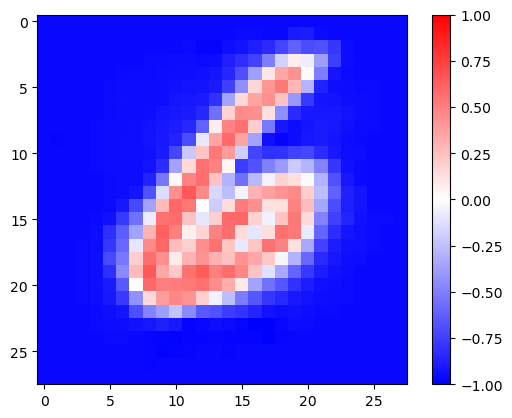

In [24]:
# we could test how well our model can classify a test case; this could definitely be done more efficiently or in a loop to quantify the network's ability 
test_idx = 500
net.output(all_Ms[N_train+test_idx])
print(net.output(all_Ms[N_train+test_idx]), np.argmax(net.output(all_Ms[N_train+test_idx])) == all_y[N_train+test_idx])

# Let's analyze a memory in our GHN which exhibits a prototype of a digit, this means that the memory's label should have -1 everywhere 
# in the label vector except in the position of the memory's corresponding digit where it should be very close to 1

# we can analyze the feature-to-prototype transition by looking at how memories are composed with respect to the training set digits! 
# the following calculates the weights by applying the Moore-Penrose inverse of the training set digits, by which we multiply it with the 
# memories of the GHN
alphas = net.Ms @ sp.linalg.pinv(t_Ms)

# this loop finds all memories that hold/are prototypes! 
L_idxs = []
for i_L,L in enumerate(net.Ls):
    if np.abs(np.abs(np.sum(L)) - 8) < 1e-3: # this finds vectors where all digits are -1 except in on position. The memory's digit
        L_idxs.append(i_L)
        # break


L_idx = np.random.choice(L_idxs) # selects one of these memories to plot the memory's espective weights! 

# let's plot the memory to see if indeed it is a prototype of a digit!
fig, ax = plt.subplots() 
im = ax.imshow(net.Ms[L_idx].reshape((28,28)), cmap='bwr', vmin=-1, vmax=1)
ax.set_aspect('equal')
plt.colorbar(im)

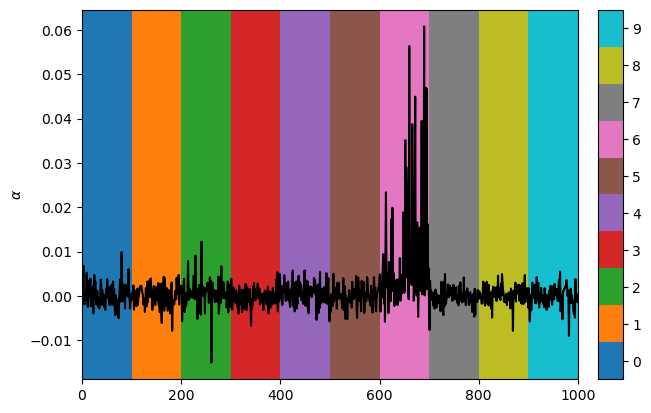

In [25]:
# the weights alpha should reflect this protoype by showing a maximum with respect to training digits that correspond to the prototype digit 
# it is important to have a colormap to show how the weights correspond to different digits 
cmap = plt.get_cmap('tab10')
norm = mpl.colors.Normalize(vmin=-0.5, vmax=9.5)
scalarMap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

# plot the distribution of alphas for a prototype memory 
fig, ax = plt.subplots() 
ax.plot(np.arange(len(SDs)*N_digit_samples), alphas[L_idx], color='k') # this can be binned to be smoother, or savgol could also be sufficient

# color background of plot for range of digit alphas correspond to
for k in range(10):
    ax.axvspan(k*N_digit_samples, (k+1)*N_digit_samples, facecolor=scalarMap.to_rgba(k))

ax.set_ylabel(r'$\alpha$')
ax.set_xlim(0,len(SDs)*N_digit_samples)
cax = ax.inset_axes([1.04, 0.0, 0.05, 1.0])
cbar = fig.colorbar(scalarMap, ax=ax, cax=cax, cmap=cmap, ticks=np.arange(10))
plt.show()

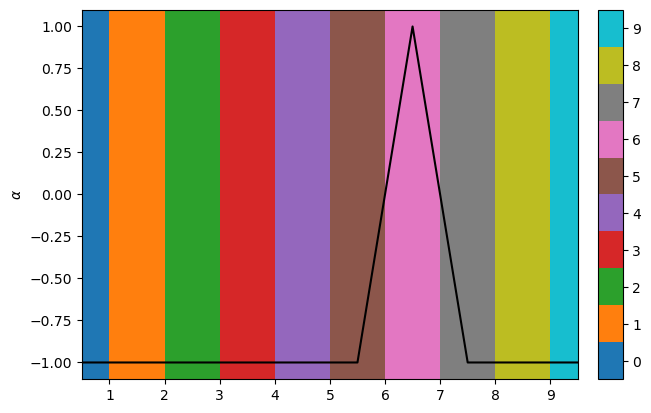

In [26]:
# plot label of this memory to show that indeed it classifies this prototype correctly!
fig, ax = plt.subplots() 
ax.plot(np.arange(10)+0.5, net.Ls[L_idx], color='k') #we are essentially plotting the distribution of the alphas as a function of the digit they were trained with 

for k in range(10):
    ax.axvspan(k, (k+1), facecolor=scalarMap.to_rgba(k))

ax.set_ylabel(r'$\alpha$')
ax.set_xlim(0.5,9.5)
cax = ax.inset_axes([1.04, 0.0, 0.05, 1.0])
cbar = fig.colorbar(scalarMap, ax=ax, cax=cax, cmap=cmap, ticks=np.arange(10))
plt.show()

In [10]:
# we visualize the dynamics of learning of the GHN using the UMAP! We do this by obtaining the manifold of the training set digits to obtain 
# a general manifold in many dimensions!   
MNIST_dat_map = umap.UMAP(random_state=4, n_neighbors=55, min_dist=0.05, metric='correlation').fit(train_Ms)

# we embed a fraction of the training digits in this manifold, along with the memories at different times of the training protocol! 
train_embedding = MNIST_dat_map.transform(train_Ms[::10])

/home/hector/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/hector/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/hector/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


/home/hector/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


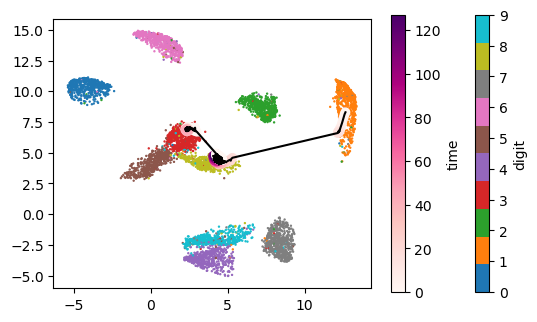

In [11]:
# we look at the dynamics of learning of a single memory starting from t = 80*5 cycles to 110*5 cycles later 
mems_idxs = [1] 
offset = 40
t_span_mems = np.arange(300,dtype=np.int8)
mem_t = np.empty((t_span_mems.size,M_len))
for k in range(t_span_mems.size):
    mem_t[k] = lib_Ms[offset+k][mems_idxs]

# fit and transform training data using the same manifold obtained from the training data
mem_embedding = MNIST_dat_map.transform(mem_t)

fig, ax = plt.subplots()     
digit_manifold = ax.scatter(train_embedding[:,0], train_embedding[:,1], s=0.5, c=train_y[::10], cmap=cmap) # points of the trajectory of the memory, colored by time
traj_mem = ax.scatter(mem_embedding[:,0], mem_embedding[:,1], c=t_span_mems, cmap='RdPu', vmin=0) # connecting line of the trayectory
ax.plot(mem_embedding[:,0], mem_embedding[:,1], c='k')
ax.set_aspect(0.8)
digit_cb = plt.colorbar(digit_manifold,shrink=0.75,ticks=np.arange(10))
digit_cb.set_label('digit')
t_cb = plt.colorbar(traj_mem,shrink=0.75)
t_cb.set_label('time')

/home/hector/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/hector/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


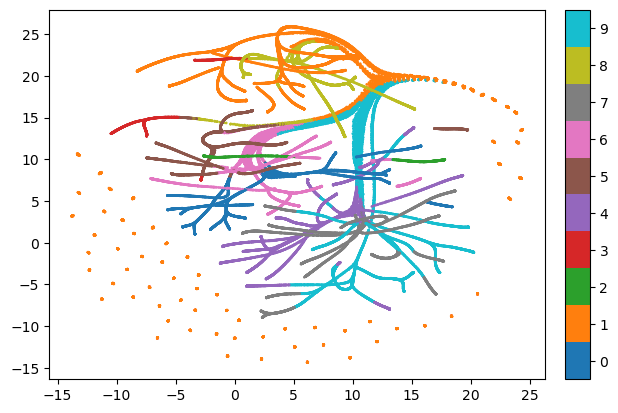

In [30]:
# we can also visualize the manifold of the contributing weights of the training set to the memories and color them 
# according to the digit the memory represents. The color is chosen by taking the maximum of the memory's label vector and 
# color according to the position of the maximum value
every = 2
alphas_t = lib_Ms[offset][::every] @ sp.linalg.pinv(t_Ms[::every]) # calculates the alphas 
L_alphas_t = np.argmax(lib_Ls[offset][::every], axis=1) #get's the digit of the memory at time t = offset*5

for k in range(1,500):
    alphas_t = np.concatenate((alphas_t, lib_Ms[offset+k][::every] @ sp.linalg.pinv(t_Ms[::every])))
    L_alphas_t = np.concatenate((L_alphas_t, np.argmax(lib_Ls[offset+k][::every], axis=1)))

alphas_embedding = umap.UMAP(random_state=4, n_neighbors=800, low_memory=True).fit_transform(alphas_t) #calculates the approximate uniform manifold and projects it onto 2D space 

fig, ax = plt.subplots()     
ax.scatter(alphas_embedding[:,0], alphas_embedding[:,1], s=1, c=L_alphas_t, cmap=cmap)
cax = ax.inset_axes([1.04, 0.0, 0.05, 1.0])
digit_cbar = fig.colorbar(scalarMap, ax=ax, cax=cax, cmap=cmap, ticks=np.arange(10), alpha=1.0)
